<a href="https://colab.research.google.com/github/eluyutao/goemotion/blob/main/Bonus_Model_TL_Nofreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 894 - SENTIMENT ANALYSIS based on Exercise 3
## Transfer learning with DistilBert
This notebook was ran after we have constructed most of our final reports. Therefore, although this model (Transfer learning using DistilBert with no freezing layers) had the highest performance, we didn't include it in our final report. We still upload the notebook to reflect our effort.
The goal of this excercise is to build a text classifier using the pretrained DistilBert published by HuggingFace. You will be doing this using the Glue/CoLA dataset (https://nyu-mll.github.io/CoLA/).



In [ ]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly
!pip install keras_tuner
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout

import tensorflow_datasets as tfds
import keras_tuner as kt

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# My additions
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
#from transformers import DefaultDataCollator

In [ ]:
!pip install emot

import pandas as pd
import emot, re
from sklearn.model_selection import train_test_split
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
pd.set_option("display.max_columns", 99)

# Get the GOEMOTIONS Datasets

In [ ]:
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv
goemotions_1 = pd.read_csv('goemotions_1.csv')
goemotions_2 = pd.read_csv('goemotions_2.csv')
goemotions_3 = pd.read_csv('goemotions_3.csv')
frames = [goemotions_1, goemotions_2, goemotions_3]
df = pd.concat(frames, ignore_index=True)

--2022-03-28 02:00:19--  http://data/full_dataset/
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
--2022-03-28 02:00:19--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 142.250.97.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘goemotions_1.csv.1’

goemotions_1.csv.1  100%[===================>]  13.52M  --.-KB/s    in 0.09s   

2022-03-28 02:00:19 (150 MB/s) - ‘goemotions_1.csv.1’ saved [14174600/14174600]

FINISHED --2022-03-28 02:00:19--
Total wall clock time: 0.2s
Downloaded: 1 files, 14M in 0.09s (150 MB/s)
--2022-03-28 02:00:19--  http://data/full_dataset/
Resolving data (data)... failed: No address associated with host

In [ ]:
print(df.shape)
df.head(2)

(211225, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Start Data Preparation

In [ ]:
%%time
# emotion label columns
lb_col = df.columns[9:]
print(f'Entire dataset: {df.shape}')
# remove examples that were very unclear. They do not have any emotions labels
df2 = df[~df['example_very_unclear']].copy()
print(f'{df2.shape[0]} rows left after removing records with unclear emotions')
# Sum the emotions together because there are different raters
df2 = df2[['text']+list(lb_col)].groupby(['text']).sum().reset_index()
print(f'{df2.shape[0]} rows left after deduping on text and id columns')
# keep records where there are at least two agreeing emotion labels
df2['at_least_2_agree'] = df2[lb_col].apply(lambda x: x.max(), axis=1)
df2 = df2[df2.at_least_2_agree >= 2]
print(df2.at_least_2_agree.unique())

Entire dataset: (211225, 37)
207814 rows left after removing records with unclear emotions
57730 rows left after deduping on text and id columns
[ 2  3  4  5  7  6 12 13 14  8 17  9 10 15 33 11 45 22]
CPU times: user 3.89 s, sys: 457 ms, total: 4.35 s
Wall time: 3.95 s


In [ ]:
for col in df2.columns[1:]:
    df2[col] = df2[col].apply(lambda x: 0 if x <= 1 else 1)

df_clean = df2.drop('at_least_2_agree', axis=1)
print(f'{df2.shape[0]} rows left after removing records without having at least two raters agreeing on the emotion')

print(df_clean.shape)
df_clean.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


53994 rows left after removing records without having at least two raters agreeing on the emotion
(53994, 29)


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(EMOTICONS_EMO[emot].split()))
    return text

In [ ]:
%%time
print('-------replacing emoji with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emojis(x))
print('-------replacing emoticon with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emoticons(x))

-------replacing emoji with text---------
-------replacing emoticon with text---------
CPU times: user 10.3 s, sys: 29.6 ms, total: 10.3 s
Wall time: 10.5 s


In [ ]:
# Based on experimentation, the emotions which are classified best have at
# least 2500 instances in the dataset.  

# The following classes are HEAVILY underrepresented in the data:
#   Emotion        Count
#   --------------------
#   grief          97
#   pride          142
#   relief         182
#   nervousness    208
#   embarrassment	 374

labels_to_drop = ['grief', 'pride', 'relief', 'nervousness', 'embarrassment']
for col in df_clean.columns[1:]:
  if col in labels_to_drop:
    df_clean[col] = 0
df_clean['sum_label'] = df_clean[1:].sum(axis=1)
df_clean = df_clean[df_clean.sum_label > 0]
df_clean.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


(53425, 30)

In [ ]:
df_clean.drop(labels=labels_to_drop+['sum_label'], inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(df_clean.shape)
X = df_clean['text']
y = df_clean.iloc[:,1:]
y.head(2)

(53425, 24)


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,excitement,fear,gratitude,joy,love,optimism,realization,remorse,sadness,surprise,neutral
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
print(y_train.shape)

(48082, 23)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=2)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (42071,)
X_val shape: (6011,)
X_test shape: (5343,)
y_train shape: (42071, 23)
y_val shape: (6011, 23)
y_test shape: (5343, 23)


In [ ]:
df_X_train = X_train.to_frame()
df_X_val   = X_val.to_frame()
df_X_test  = X_test.to_frame()

Next, we need to prepare the text for DistilBert. Instead of ingesting raw text, the model uses token IDs to map to internal embedding. Additionally, since the input is fixed size (due to our use of batches), we need to let the model know which tokens to use (i.e. are part of the sentence).

Luckily, `dbert_tokenizer` takes care of all that for us - 
- Preprocessing: https://huggingface.co/transformers/preprocessing.html
- Summary of tokenizers (DistilBert uses WordPiece): https://huggingface.co/transformers/tokenizer_summary.html#wordpiece

In [ ]:
def make_y_a_numpy_array(df):
  y = df.to_numpy()
  return y


def encode_text(text):

    batch_size = 128
    input_ids = []
    attention_mask = []

    temp = text['text'].to_list()
    for count in range(0, len(text), batch_size):
      batch_text = temp[count:count+batch_size]
      # have to truncate b/c was resulting in a non-rectangular shape
      output = dbert_tokenizer(batch_text,
                             padding='max_length',
                             return_attention_mask=True,
                             max_length=256, #96  # was 512, but took waay too long
                             truncation=True
                             )
      input_ids.extend(output['input_ids'])
      attention_mask.extend(output['attention_mask'])

    # Try switching everything to numpy arrays
    input_ids = np.array(input_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, attention_mask

# the following prepares the input for running in DistilBert
np_array_y_train = make_y_a_numpy_array(y_train)
np_array_y_val   = make_y_a_numpy_array(y_val)
np_array_y_test  = make_y_a_numpy_array(y_test)

train_input, train_mask = encode_text(df_X_train)
val_input, val_mask = encode_text(df_X_val)
test_input, test_mask = encode_text(df_X_test)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

test_model_inputs_and_masks = {
    'inputs' : test_input,
    'masks' : test_mask
}

# Modelling

## Build and Train Model


In [ ]:
def build_model(base_model, trainable=True, params={}):

    max_seq_len = params['max_seq_len']
    layer_dropout = params['layer_dropout']
    random_seed = params['random_seed']

    initial_weights = keras.initializers.GlorotNormal(seed=random_seed)

    inputs = Input(shape=(max_seq_len,), 
                   name='input_ids', 
                   dtype='int32')
    masks  = Input(shape=(max_seq_len,), 
                   name='input_attention', 
                   dtype='int32')

    base_model.trainable = trainable

    dbert_output = base_model(inputs, attention_mask=masks)

    dbert_last_hidden_state = dbert_output.last_hidden_state


    # Any additional layers
    cls_token = dbert_last_hidden_state[:, 0, :]
    X = tf.keras.layers.BatchNormalization()(cls_token)
    X = tf.keras.layers.Dense(192, activation='relu')(X)
    X = tf.keras.layers.Dropout(layer_dropout)(X)

    my_output = X
    probs = Dense(23,
                  activation='sigmoid',
                  kernel_initializer=initial_weights,  
                  kernel_constraint=None,
                  bias_initializer='zeros'
                  )(my_output)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
params= {
        "max_seq_len":256,
        "layer_dropout":0.25,
        "learning":0.00005,
        "random_seed":91
        }

model = build_model(dbert_model, params=params)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 256, 768),                                                   
                                 hidden_states=None                                         

In [ ]:
def compile_model(model):

    # Metrics
    #     "Hamming loss is the fraction of wrong labels to the total number of labels.
    #      In multi-class classification, hamming loss is calculated as the hamming 
    #      distance between y_true and y_pred. In multi-label classification, hamming
    #      loss penalizes only the individual labels.""
    metrics = [tfa.metrics.HammingLoss(mode='multiclass', name='hamming-mc', dtype=tf.float32, threshold=0.2),
               tfa.metrics.HammingLoss(mode='multilabel', name='hamming-ml', dtype=tf.float32, threshold=0.4),
               keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
               keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32, label_smoothing=0.5),
               keras.metrics.CategoricalAccuracy()]

    # Loss
    #loss = keras.losses.SparseCategoricalCrossentropy()
    
    # Switch to Categorical to support multi-class classification
    #    loss = keras.losses.CategoricalCrossentropy()
    # Try binary cross-entropy and switch model to sigmoid
    #    loss = keras.losses.BinaryCrossentropy()
    # Use a new one from TFA

    loss = tfa.losses.SigmoidFocalCrossEntropy()

    model.compile(keras.optimizers.Adam(learning_rate=params['learning']), 
                  loss=loss,
                  metrics=metrics)

    return model

model = compile_model(model)

In [ ]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):
    history = model.fit(x = [model_inputs_and_masks_train["inputs"], 
                        train_model_inputs_and_masks["masks"]],
                        y = y_train,
                        batch_size=batch_size, epochs=num_epochs, 
                        validation_data=([model_inputs_and_masks_val["inputs"],
                                          model_inputs_and_masks_val["masks"]],
                                         y_val),
                        verbose=2)

    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, np_array_y_train, np_array_y_val, batch_size=32, num_epochs=2)

Epoch 1/2
1315/1315 - 690s - loss: 0.6837 - hamming-mc: 0.3312 - hamming-ml: 0.0921 - Cat-CE: 3.3718 - Bin-CE: 0.7005 - categorical_accuracy: 0.2322 - val_loss: 0.2945 - val_hamming-mc: 0.2592 - val_hamming-ml: 0.0414 - val_Cat-CE: 2.5156 - val_Bin-CE: 0.6913 - val_categorical_accuracy: 0.4964 - 690s/epoch - 525ms/step
Epoch 2/2
1315/1315 - 677s - loss: 0.3631 - hamming-mc: 0.1574 - hamming-ml: 0.0495 - Cat-CE: 2.5964 - Bin-CE: 0.7091 - categorical_accuracy: 0.4602 - val_loss: 0.2669 - val_hamming-mc: 0.0705 - val_hamming-ml: 0.0387 - val_Cat-CE: 2.2738 - val_Bin-CE: 0.6943 - val_categorical_accuracy: 0.5540 - 677s/epoch - 515ms/step


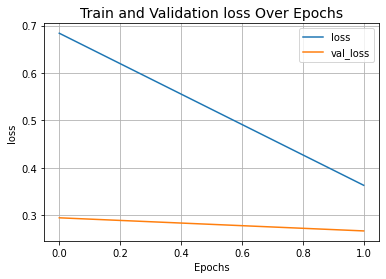

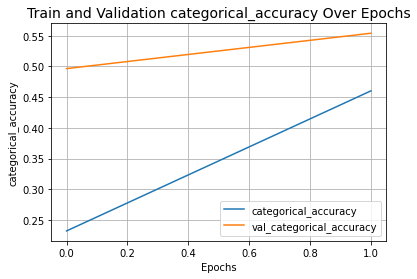

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
test_df = pd.DataFrame()
labels = []
predicts = []
iteration = []

def eval_model(model, inputs_and_masks, label):

    test_scores = model.evaluate(x = [inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"]],
                        y = label, verbose=2)
    test_loss = test_scores[0]
    test_metrics = test_scores[1]
    print("Test loss:", test_loss)
    print("Test accuracy:", test_metrics)
    
    # collect the first 30 predictions looking for incorrect ones
    predictions = model.predict([inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"]])
    for i in range(len(predictions)):
      labels.append(label[i])
      predicts.append(predictions[i])
      iteration.append(i)

    test_df['Labels'] = labels
    test_df['Predictions'] = predicts
    test_df['Iteration'] = iteration
    return test_loss, test_metrics

test_loss, test_metrics = eval_model(model, test_model_inputs_and_masks, np_array_y_test)

167/167 - 28s - loss: 0.2761 - hamming-mc: 0.0780 - hamming-ml: 0.0391 - Cat-CE: 2.3094 - Bin-CE: 0.6938 - categorical_accuracy: 0.5343 - 28s/epoch - 168ms/step
Test loss: 0.27611035108566284
Test accuracy: 0.0780460387468338


In [ ]:
rounded_pred = []

test_df['Rounded_Pred'] = test_df['Predictions'].copy()

for i in range(test_df.shape[0]):
  arr = test_df['Rounded_Pred'][i]
  arr[arr <= 0.2] = 0
  arr[arr > 0.2] = 1
  rounded_pred.append(arr)

test_df['Rounded_Pred'] = rounded_pred
test_df.head()

,Labels,Predictions,Iteration,Rounded_Pred
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",3,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...",4,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."


## Custom Multi-label Accuracy metric

Thiebaut N. Multi-label classification with BERT. Data4thought: data science blog. Published January 29, 2021. Accessed March 25, 2022. https://data4thought.com/toxic_comments_transformer.html

In [ ]:
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [ ]:
metric2 = tfa.metrics.HammingLoss(mode='multiclass', threshold=0.2)

y_true = tf.convert_to_tensor(labels, dtype=tf.float32)
y_pred = tf.convert_to_tensor(predicts, dtype=tf.float32)

metric2.update_state(y_true, y_pred)
print("Hamming distance: ", metric2.result().numpy())

metric3 = tf.keras.metrics.KLDivergence()
metric3.update_state(y_true, y_pred)
print("\nKL Divergence: ", metric3.result().numpy())

metric4 = tf.keras.metrics.Accuracy()
metric4.update_state(y_true, y_pred)
print("\nAccuracy: ", metric4.result().numpy())

metric6 = tfa.metrics.F1Score(num_classes=23, threshold=0.5) # was 28 classes
metric6.update_state(y_true, y_pred)
print("\nF1 Score: ", metric6.result().numpy())

metric7 = tf.keras.metrics.SensitivityAtSpecificity(0.85)
metric7.update_state(y_true, y_pred)
print("\nSensitivity: ", metric7.result().numpy())

metric8 = multi_label_accuracy(y_true, y_pred)
#assert metric8.shape == (2,)
print("\nMulti-label Accuracy: ", metric8)

metric5 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=23) # was 28 classes
metric5.update_state(y_true, y_pred)
print("\nMulti-label Confusion Matrices: \n", metric5.result().numpy())

Hamming distance:  0.07804604

KL Divergence:  4.036307

Accuracy:  0.874407

F1 Score:  [0.44105262 0.7629428  0.4879121  0.21789473 0.19839357 0.32758623
 0.21379833 0.5096701  0.3197026  0.2857143  0.1792183  0.24622029
 0.22935781 0.40441176 0.8429752  0.43760684 0.7475083  0.24905662
 0.12903225 0.08424909 0.4        0.41564792 0.61364436]

Sensitivity:  0.7863985

Multi-label Accuracy:  tf.Tensor(0.1903425, shape=(), dtype=float32)

Multi-label Confusion Matrices: 
 [[[3862.  986.]
  [  76.  419.]]

 [[4889.  139.]
  [  35.  280.]]

 [[4999.  139.]
  [  94.  111.]]

 [[3650. 1382.]
  [ 104.  207.]]

 [[3100. 1882.]
  [ 114.  247.]]

 [[5052.  140.]
  [  94.   57.]]

 [[4165. 1001.]
  [  36.  141.]]

 [[4688.  408.]
  [  23.  224.]]

 [[5117.  150.]
  [  33.   43.]]

 [[5097.   93.]
  [ 112.   41.]]

 [[3433. 1665.]
  [  57.  188.]]

 [[4937.  311.]
  [  38.   57.]]

 [[5150.  104.]
  [  64.   25.]]

 [[5126.  135.]
  [  27.   55.]]

 [[4923.   95.]
  [  19.  306.]]

 [[4886.  276

In [ ]:
from sklearn.metrics import precision_score, recall_score
prcsn = precision_score(y_true, y_pred, average=None)
rcl = recall_score(y_true, y_pred, average=None)
print('precision: ', prcsn, '\n')
print('recall: ', rcl)

precision:  [0.29822064 0.66825776 0.444      0.13027061 0.11601691 0.2893401
 0.1234676  0.35443038 0.22279793 0.30597015 0.1014571  0.1548913
 0.19379845 0.28947368 0.76309227 0.31683168 0.63380282 0.14692787
 0.19672131 0.04423077 0.29329609 0.30909091 0.45032425] 

recall:  [0.84646465 0.88888889 0.54146341 0.66559486 0.68421053 0.37748344
 0.79661017 0.90688259 0.56578947 0.26797386 0.76734694 0.6
 0.28089888 0.67073171 0.94153846 0.70718232 0.91093117 0.81683168
 0.096      0.88461538 0.62874251 0.63432836 0.96283971]


In [ ]:
metric2 = tfa.metrics.HammingLoss(mode='multiclass', threshold=0.2)

y_true = tf.convert_to_tensor(labels, dtype=tf.float32)
y_pred = tf.convert_to_tensor(predicts, dtype=tf.float32)

metric2.update_state(y_true, y_pred)
print("Hamming distance: ", metric2.result().numpy())


f1 = tfa.metrics.F1Score(num_classes=23, threshold=0.5)
f1.update_state(y_true, y_pred)
print("\nF1 Score: ", f1.result().numpy())

Hamming distance:  0.07804604

F1 Score:  [0.44105262 0.7629428  0.4879121  0.21789473 0.19839357 0.32758623
 0.21379833 0.5096701  0.3197026  0.2857143  0.1792183  0.24622029
 0.22935781 0.40441176 0.8429752  0.43760684 0.7475083  0.24905662
 0.12903225 0.08424909 0.4        0.41564792 0.61364436]


In [ ]:
perf_report = pd.DataFrame([prcsn, rcl, f1.result().numpy()], columns=y_train.columns).T
perf_report.rename(columns={0:'Precision', 1:'Recall', 2:'F1'}, inplace=True)
perf_report

,Precision,Recall,F1
admiration,0.298221,0.846465,0.441053
amusement,0.668258,0.888889,0.762943
anger,0.444000,0.541463,0.487912
annoyance,0.130271,0.665595,0.217895
approval,0.116017,0.684211,0.198394
caring,0.289340,0.377483,0.327586
confusion,0.123468,0.796610,0.213798
curiosity,0.354430,0.906883,0.509670
desire,0.222798,0.565789,0.319703
disappointment,0.305970,0.267974,0.285714
